# Experiment A: Bound Adherence Under Nonstationary Conditions
*Question: does empirical average regret stay within the $\gamma$-regret bounds?*

### Experiment Design
Grid search over the streams (stationary, slow, abrupt, periodic), lambda levels, and two deletion ratio regimes.

Use a static comparator and calibrated learning rate schedule.
Set gamma per-theory at calibration and fix the total horizon (ie. $T=50000$).

### Primary Analysis
For each of the experimental cells, evaluate the final $R_{T}/T$ to see whether the guarantee was met.
Multiple seeds per cell in order to make some kind of causal analysis on the results.

### Success Criteria
95% of the cells meet their guarantees then I would call that a success. Which cells experience more successes than others? Can I make a heatmap that shows the regret results per cell?

## Import Statements and Versioning

This uses pretty standard library imports, but the torch requirement can stress the memory limits of a host.

In [1]:
# set global seed
import random
import numpy as np
import pandas as pd
import torch

def set_seed(seed):
    """
    Set the random seed for reproducibility.
    
    Args:
        seed (int): The seed value to set for random number generation.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Config and Target

In [2]:
RUN_ID = "experiment_a_test"
REGIME = "stationary"
REPLICATE = 1
T = 1000
SEED = 42
LOSS_NAME = "logistic"
MODEL_NAME = "memorypair"
LBFGS_MEM = 10

# Setup and Imports

In [3]:
# Import required modules
import sys
import os

# Add code path for imports
os.chdir(os.path.dirname(os.getcwd()))

from config import Config
from runner import ExperimentRunner

from agents.grid_runner import load_grid, generate_combinations, create_grid_id, run_parameter_combination


import os, json
import yaml

GRID_FILE = "grids.yaml"
BASE_OUT = "results/grid_2025_08_15"   # date-stamp it
OUTPUT_GRANULARITY = "event"           # Experiment A wants per-event for the money plot
SEEDS = list(range(5))                 # match your CLI default

# Load grid config from YAML
with open(GRID_FILE, "r") as f:
    grid_config = yaml.safe_load(f)


combos = generate_combinations(grid_config)

# select 60 combinations randomly 
cases = random.sample(combos, 10)

print(f"{len(combos)} grid cells")
print(f"sampled {len(cases)} cells to run")

# (Optional) dry-run preview
for i, p in enumerate(cases[:5]):
    print(f"{i+1:2d}. {create_grid_id(p)} → {p}")

# Make output dirs
os.makedirs(os.path.join(BASE_OUT, "sweep"), exist_ok=True)

# Run the sweep using ExperimentRunner
all_csv = []
for i, params in enumerate(cases):
    print(f"\n=== Running cell {i+1}/{len(combos)}: {create_grid_id(params)} ===")
    csvs = run_parameter_combination(
        params=params,
        seeds=SEEDS,
        base_out_dir=BASE_OUT,
        output_granularity=OUTPUT_GRANULARITY,
        parallel=1,           # bump if your runner supports safe parallelism in-notebook
    )
    all_csv.extend(csvs)

# Persist a manifest like the CLI does (handy for analysis notebooks)
manifest = { create_grid_id(p): p for p in combos }
with open(os.path.join(BASE_OUT, "sweep", "manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

print("\nDone. CSVs:", len(all_csv))


## Reading and Transforming the Data 

The data is now in a series of files in the results folder. This section will read in those datapoints and output a fully formatted dataframe of a random sample of the datapoints.

Analysis can be performed in batches.

In [4]:
# print a count of all directories in the results directory
dir_list = []
results_dir = "results/grid_2025_01_01/"
for r, d, files in os.walk(results_dir):
    for dirname in d:
        dir_list.append(os.path.join(r, dirname))
print(f"Number of directories in '{results_dir}': {len(dir_list)}")
print(dir_list)

Number of directories in 'results/grid_2025_01_01/': 243
['results/grid_2025_01_01/sweep', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_heb5a709a', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_h18f7a5ca', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_h57aed601', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_h62db51a8', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_h8321c7ec', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_h0d7fe9e2', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_h26a9dd6a', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_h4f38617b', 'results/grid_2025_01_01/sweep/gamma_

In [5]:
# sample 12 of the directories
sampled_directories = random.sample(dir_list, 12)
print(sampled_directories)

# read them into a dataframe

# go up a single level in the current directory
sys.path.append(os.path.dirname(os.getcwd()))


event_data = []
parameter_data = []
for d in sampled_directories:
    # ingest all csv files
    for f in os.listdir(d):
        if f.endswith('memorypair.csv'):
            df = pd.read_csv(os.path.join(d, f))
            df['grid_id'] = d.split('/')[-1]
            # append the seed from the filename
            df['seed'] = int(f.split('_')[1])
            event_data.append(df)
        elif f.endswith('.json'):
            df = pd.read_json(os.path.join(d, f))
            df['grid_id'] = d.split('/')[-1]
            # append the seed from the filename
            print(f.split('_')[1])
            df['seed'] = f.split('_')[1]
            df['seed'] = int(df['seed'].split('.')[0])
            parameter_data.append(df)

# concatenate all dataframes
event_data = pd.concat(event_data, ignore_index=True)
parameter_data = pd.concat(parameter_data)


['results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_hec4bf46b', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_h4736bf22', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_hd7ac487b', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_h41713e54', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_h92565eca', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_h22306854', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_h5314507c', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_he9d8e50c', 'results/grid_2025_01_01/sweep/gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_ang0.01_dr0.001_fs1_h50cd340b', 'results/grid_2025

IndexError: list index out of range

In [ ]:
all_data = event_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], errors='ignore')

## Regret Analysis

The question of interest is whether the learner met its regret guarantees. 

I calculate this by seeing the regret of the learner at the end of its Interleaved sequence.

TO DO: Check and make sure that the `max_events` parameter is used to calibrate the noise injection as opposed to some higher number.


In [ ]:
seed_data = event_data[['grid_id','seed','event', 'regret']]
seed_analysis = seed_data.groupby(['grid_id','seed']).max(["event", "regret"]).reset_index()
seed_analysis.columns = ['grid_id', 'seed', 'max_event', 'max_regret']
seed_analysis['regret'] = seed_analysis['max_regret'] / seed_analysis['max_event']
seed_data["average_regret"] = seed_data['regret'] / seed_data['event']
seed_analysis.head()

/tmp/ipykernel_46645/1415334769.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_data["average_regret"] = seed_data['regret'] / seed_data['event']


,grid_id,seed,max_event,max_regret,regret
0,gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_...,0,9999,48306.794886,4.831163
1,gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_...,1,9999,20211.313589,2.021333
2,gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_...,2,9999,56521.934466,5.652759
3,gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_...,3,9999,170522.472727,17.053953
4,gamma_1.0-split_0.3_q0.90_k3_zcdp_eps1.0_prot_...,4,9999,109807.540366,10.981852


In [ ]:
# pick a random Grid ID
random_grid_id = seed_data['grid_id'].sample().iloc[0]
# filter the seed data for the selected Grid ID
filtered_seed_data = seed_data[seed_data['grid_id'] == random_grid_id]

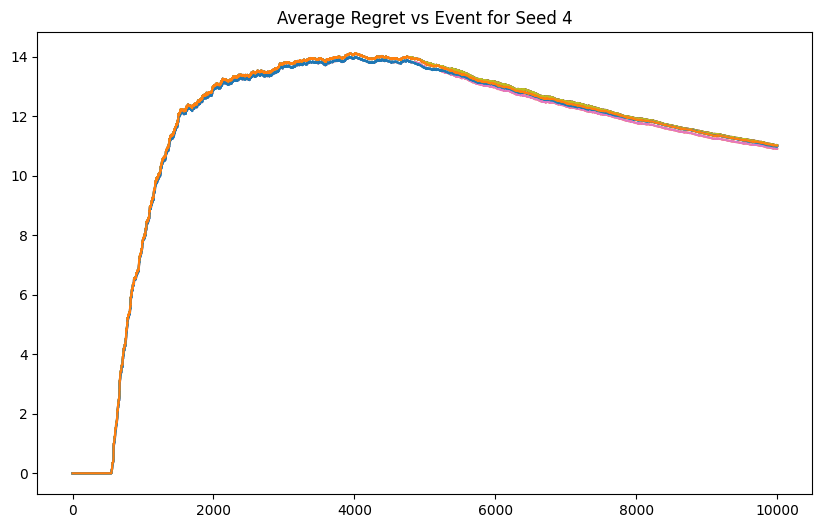

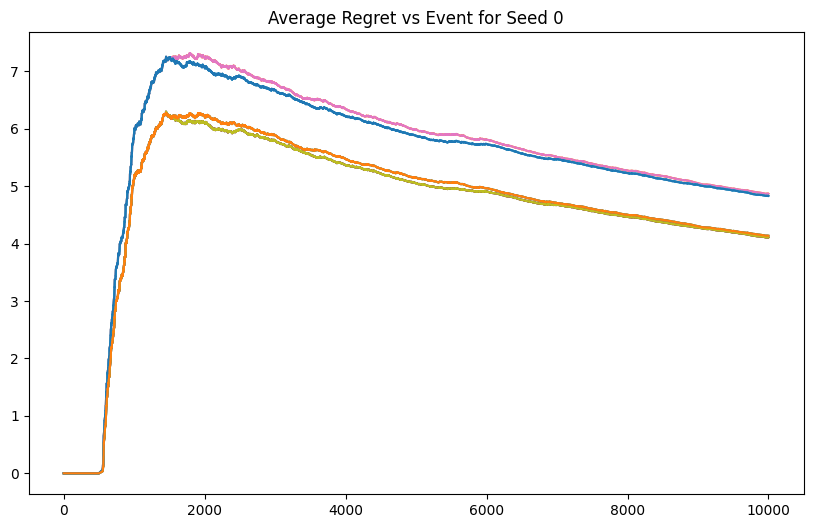

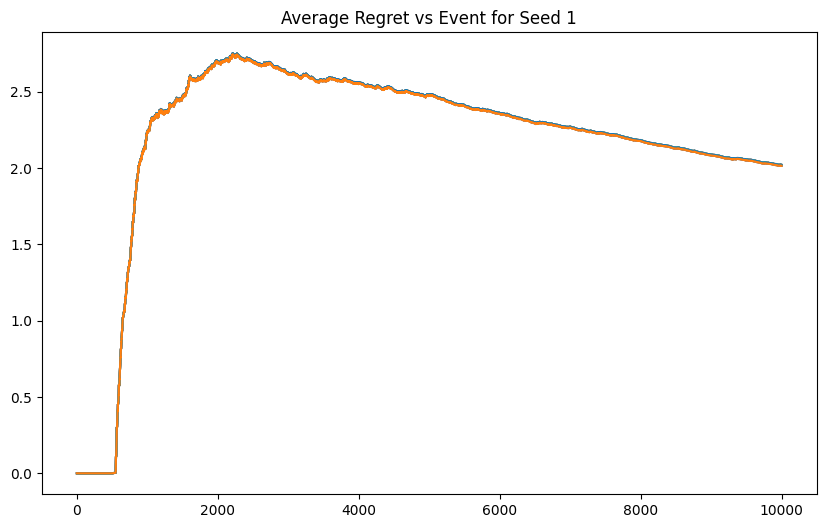

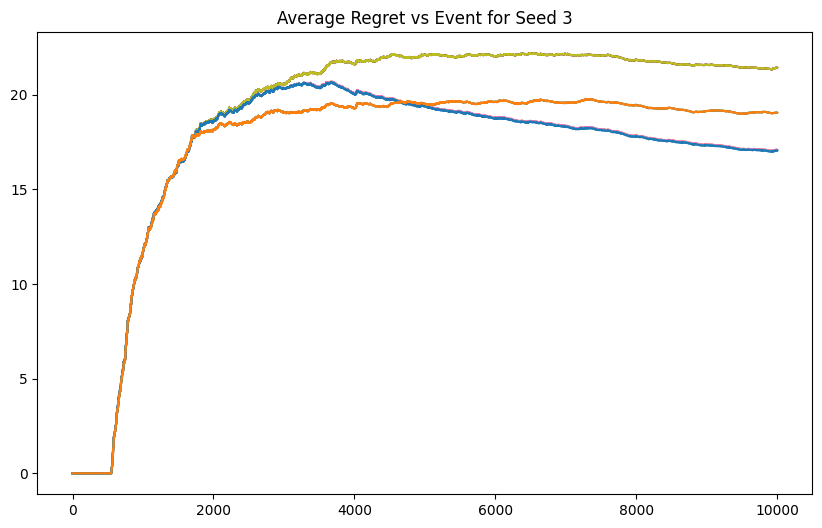

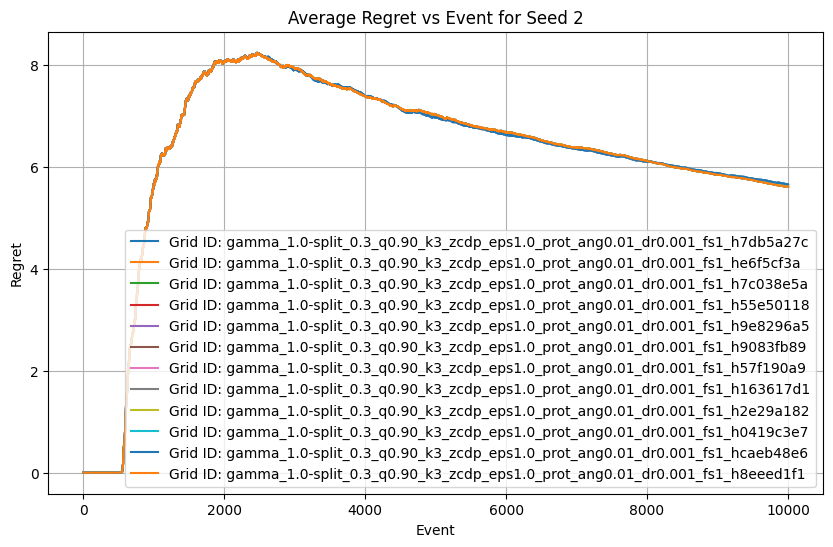

In [ ]:
# create one plot per seed and one line per grid ID

import matplotlib.pyplot as plt

for seed in seed_data['seed'].unique():
    plt.figure(figsize=(10, 6))
    for grid_id in seed_data['grid_id'].unique():
        plt.plot(seed_data.loc[(seed_data['grid_id'] == grid_id) & (seed_data['seed'] == seed)]['event'],
                 seed_data.loc[(seed_data['grid_id'] == grid_id) & (seed_data['seed'] == seed)]['average_regret'],
                 label=f"Grid ID: {grid_id}")
        plt.title(f"Average Regret vs Event for Seed {seed}")
plt.xlabel("Event")
plt.ylabel("Regret")
plt.grid()
plt.legend()
plt.show()